Analytic Variational Bayes. Inferring a single Gaussian
=====================

This notebook implements the example from section 3 of the FMRIB tutorial on Variational Bayes ("Inferring a single Gaussian").

We assume we have data drawn from a Gaussian distribution with true mean $\mu$ and true precision $\beta$:

$$
P(y_n | \mu, \beta) = \frac{\sqrt{\beta}}{\sqrt{2\pi}} \exp{-\frac{\beta}{2} (y_n - \mu)^2}
$$

One interpretation of this is that our data consists of repeated measurements of a fixed value ($\mu$) combined with Gaussian noise with standard deviation $\frac{1}{\sqrt{\beta}}$.

Here's how we can generate some sample data from this model in Python:

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
# Ground truth parameters
# We infer the precision, BETA, but it is useful to
# derive the variance and standard deviation from it
MU_TRUTH = 42
BETA_TRUTH = 0.5
VAR_TRUTH = 1/BETA_TRUTH
STD_TRUTH = np.sqrt(VAR_TRUTH)

# Observed data samples are generated by Numpy from the ground truth
# Gaussian distribution. Reducing the number of samples should make
# the inference less 'confident' - i.e. the output variances for
# MU and BETA will increase
N = 100
DATA = np.random.normal(MU_TRUTH, STD_TRUTH, [N])
print("Data samples are:")
print(DATA)

Data samples are:
[39.75298832 41.4160708  44.19581882 41.53915963 44.10273382 41.77481023
 43.43077623 42.20317982 41.77566596 43.50840665 40.4800755  40.91481196
 43.80733815 43.17623785 41.804317   42.01507837 41.3941962  41.89138895
 43.51950255 43.07276443 41.8492612  40.46214771 43.36343974 42.00828589
 42.61950312 42.32787099 40.61827976 41.60510964 41.27777179 43.52877185
 41.8164611  45.34212508 43.0730949  40.19725172 43.63098837 41.14752243
 41.72800603 42.29542761 42.07562134 43.14057696 39.90633734 43.47140882
 42.24431716 40.9531533  43.7311171  43.44385323 42.37327604 42.18112766
 42.6152795  40.68502959 40.88138282 39.69846369 40.19345115 43.38738199
 42.65798983 44.32454582 41.88812009 42.56907405 39.59862994 44.3801136
 42.99105128 40.27619831 42.71957366 41.09168873 39.59750992 45.2813477
 42.79174717 43.35673813 43.21306432 43.1617879  42.65566817 42.24608877
 40.55812315 40.58325832 41.63416219 42.73968344 39.92406388 42.14089635
 41.71123769 42.02163357 41.7200862

In the 'signal + noise' interpretation we can view this as noisy measurements (red crosses) of a constant signal (green line):

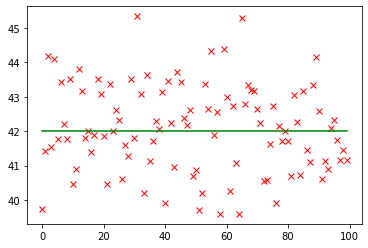

In [2]:
#from matplotlib import pyplot as plt
plt.figure()
plt.plot(DATA, "rx")
plt.plot([MU_TRUTH] * N, "g")

In Variational Bayes we make the approximation that the posterior is factorised with respect to these two parameters:

$$q(\mu, \beta) = q(\mu)q(\beta)$$

Generally it is a requirement for the analytic formulation of Variational Bayes that the 'noise' and 'signal' parameters are factorised. In more complex examples where there is more than one 'signal' parameter (e.g. we are inferring the parameters of a complex nonlinear model), a combined distribution may be used for the multiple signal parameters, however the noise must still be factorised.

Another requirement for analytic VB is the choice of 'conjugate' distributions for the priors $P(\mu)$, $P(\beta)$, and the posteriors $q(\mu)$ and $q(\beta)$. This arises from Bayes's theorem which in our approximate form is:

$$q(\mu)q(\beta) \propto P(\textbf{Y} | \mu, \beta)P(\mu)P(\beta)$$

Here, $P(\textbf{Y} | \mu, \beta)$ is the likelihood and is determined from the Gaussian data model given above. It turns out that if we choose certain types of distribution for the priors $P(\mu)$ and $P(\beta)$, then $q(\mu)$ and $q(\beta)$ will end up having the same type of distribution. These 'special' distributions are known as the 'conjugate' distributions *for the likelihood*. Conjugate distributions depend on the exact form of the likelihood function.

We will not prove the conjugate distributions for this likelihood, but will simply state that for a Gaussian data model as above, the conjugate distribution for $\mu$ is Gaussian, the the conjugate distribution for $\beta$ is a Gamma distribution:

$$P(\mu) = \frac{1}{\sqrt{2\pi v_0}} \exp{-\frac{1}{2v_0}(\mu - m_0)^2}$$
$$q(\mu) = \frac{1}{\sqrt{2\pi v}} \exp{-\frac{1}{2v}(\mu - m)^2}$$

Here $m$ and $v$ are the 'hyperparameters' of the posterior for $\mu$ - they determine the inferred posterior distribution of 
$\mu$, and through the VB formulation we will infer values for them from the data. $m_0$ and $v_0$ similarly describe our prior knowledge of the likely value of $\mu$ and might incorporate existing knowledge. Alternatively by choosing a large value of $v_0$ we can have a 'non-informative' prior which would be used if we have no real idea before seeing the data what the value of $\mu$ might be.

Similarly for $\beta$ we have:

$$P(\beta) = \frac{1}{\Gamma(c_0)}\frac{\beta^{c_0-1}}{b_0^{c_0}}\exp{-\frac{\beta}{b_0}}$$
$$q(\beta) = \frac{1}{\Gamma(c)}\frac{\beta^{c-1}}{b^c}\exp{-\frac{\beta}{b}}$$

Here $b$ and $c$ are the inferred hyperparameters and $b_0$ and $c_0$ are the prior scale and shape parameters for the Gamma distribution. The mean of the Gamma distribution is given by $cb$ and the variance by $cb^2$. 

Sometimes it may be more intuitive to think of the Gamma prior in terms of a mean and variance in which case we can derive the prior hyperparameters as:

$$b_0 = \frac{\textrm{Prior variance}}{\textrm{Prior mean}}$$
$$c_0 = \frac{\textrm{Prior mean}^2}{\textrm{Prior variance}}$$

Here we'll define some non-informative priors for $\mu$ and $\beta$. Note that for the noise prior, $\beta$ we define the prior mean and variance and derive the prior hyperparameters $b_0$ and $c_0$ from this:

In [3]:
m0 = 0
v0 = 1000
beta_mean0 = 1
beta_var0 = 1000
b0 = beta_var0 / beta_mean0
c0 = beta_mean0**2 / beta_var0
print("Priors: P(mu) = N(%f, %f), P(beta) = Ga(%f, %f)" % (m0, v0, b0, c0))

Priors: P(mu) = N(0.000000, 1000.000000), P(beta) = Ga(1000.000000, 0.001000)


Next we need the update equations. These will take existing values of $m$, $v$, $b$ and $c$ and produce new estimates. By repeatedly iterating we will converge on the optimal posterior hyperparameters.

Here we implement the update equations as a Python function which takes values of $m$, $v$, $b$ and $c$ and returns updated values.

In [4]:
# Equation 3.15 - these depend only on the data
S1 = np.sum(DATA)
S2 = np.sum(np.square(DATA))

def update(m, v, b, c):
    # Equation 3.17
    m = (m0 + v0 * b * c * S1) / (1 + N * v0 * b * c)

    # Equation 3.18
    v = v0 / (1 + N * v0 * b * c)

    # Equation 3.20
    X = S2 - 2*S1*m + N * (m**2 + v)

    # Equation 3.21
    b = 1 / (1 / b0 + X / 2)
    
    # Equation 3.22
    c = N / 2 + c0
    
    return m, v, b, c


The iterative process needs some starting values which we define similarly to the priors. We could in fact start off with the prior values. If the iterative process is working the starting values should not matter, however in more complex problems it is important to start out with reasonable values of the parameters or the iteration can become stuck in a local maximum and not find the best solution.

In [5]:
m = 0
v = 10
beta_mean1 = 1.0
beta_var1 = 10
b = beta_var1 / beta_mean1
c = beta_mean1**2 / beta_var1
print("Initial values: (m, v, b, c) = (%f, %f, %f, %f)" % (m, v, b, c))

Initial values: (m, v, b, c) = (0.000000, 10.000000, 10.000000, 0.100000)


Note that our initial values are not particularly close to the true values, so we are not cheating!

Finally, let's iterate 10 times and see what happens to the hyperparameters:

In [6]:
for vb_iter in range(10):
    m, v, b, c = update(m, v, b, c)
    print("Iteration %i: (m, v, b, c) = (%f, %f, %f, %f)" % (vb_iter+1, m, v, b, c))

print("Inferred mean/precision of Gaussian: %f, %f" % (m, c * b))
print("Inferred variance on Gaussian mean/precision: %f, %f" % (v, c * b**2))

Iteration 1: (m, v, b, c) = (42.086150, 0.010000, 0.012312, 50.001000)
Iteration 2: (m, v, b, c) = (42.085888, 0.016244, 0.012265, 50.001000)
Iteration 3: (m, v, b, c) = (42.085885, 0.016306, 0.012264, 50.001000)
Iteration 4: (m, v, b, c) = (42.085885, 0.016307, 0.012264, 50.001000)
Iteration 5: (m, v, b, c) = (42.085885, 0.016307, 0.012264, 50.001000)
Iteration 6: (m, v, b, c) = (42.085885, 0.016307, 0.012264, 50.001000)
Iteration 7: (m, v, b, c) = (42.085885, 0.016307, 0.012264, 50.001000)
Iteration 8: (m, v, b, c) = (42.085885, 0.016307, 0.012264, 50.001000)
Iteration 9: (m, v, b, c) = (42.085885, 0.016307, 0.012264, 50.001000)
Iteration 10: (m, v, b, c) = (42.085885, 0.016307, 0.012264, 50.001000)
Inferred mean/precision of Gaussian: 42.085885, 0.613228
Inferred variance on Gaussian mean/precision: 0.016307, 0.007521


The update equations in this case converge within just a couple of iterations and lead to inferred hyperparameters close to our ground truth. Note also that we have inferred the variance on these parameters - this gives an indication of how confident we can be in their values. If you try reducing the number of samples in the data set the variance will increase since we have less information to infer $\mu$ and $\beta$.

We can plot the inferred value of $\mu$ with error bars derived from the inferred variance:
 

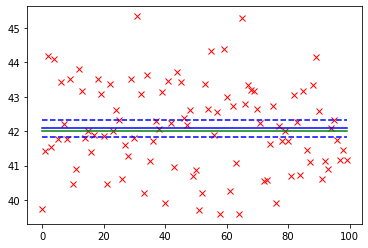

In [7]:
plt.figure()
plt.plot(DATA, "rx")
plt.plot([MU_TRUTH] * N, "g")
plt.plot([m] * N, "b")
plt.plot([m+2*np.sqrt(v)] * N, "b--")
plt.plot([m-2*np.sqrt(v)] * N, "b--")


Other things to try would include:

 - Reducing the variance of the priors, i.e. make them informative. This will cause the inferred values to move closer to the
   prior values because we are now claiming we have prior knowledge of what $\mu$ and $\beta$ must be, and this can to some
   extent override the information in the data.
   
 - Changing the initial values of $m$, $v$, $b$ and $c$ to verify that the iteration can still converge to the correct    
   solution.
 
 - Try modifying the ground truth values and verify that we still infer the correct solution.
 
 - Increasing the level of noise should cause the variance estimates in the parameters to go up
 - Reducing the number of data samples should also increase the variance estimates to go up since we have less information to go on.
 

### Simple implementation of analytic Variational Bayes to infer a nonlinear forward model (optional)

=============

This implements section 4 of the FMRIB Variational Bayes tutorial 1
for a single exponential decay model

$g(\theta)=A\exp^{-\lambda t}$

In [8]:
import numpy as np

This starts the random number generator off with the same seed value each time, so the results are repeatable. However it is worth changing the seed (or simply removing this line) to see how different data samples affect the results

In [9]:
np.random.seed(0)

In [10]:
# Ground truth parameters
A_TRUTH = 42
LAM_TRUTH = 1.5
NOISE_PREC_TRUTH = 100
NOISE_VAR_TRUTH = 1/NOISE_PREC_TRUTH
NOISE_STD_TRUTH = np.sqrt(NOISE_VAR_TRUTH)

Observed data samples are generated by Numpy from the ground truth Gaussian distribution. Reducing the number of samples should make the inference less 'confident' - i.e. the output variances for MU and BETA will increase

In [11]:
def model(t, a, lam):
    """
    Simple exponential decay model
    """
    return a * np.exp(-lam * t)


N = 100
DT = 0.2
t = np.array([float(t)*DT for t in range(N)])
DATA_CLEAN = model(t, A_TRUTH, LAM_TRUTH)
DATA_NOISY = DATA_CLEAN + np.random.normal(0, NOISE_STD_TRUTH, [N])
print("Data samples are:")
print(t)
print(DATA_CLEAN)
print(DATA_NOISY)

Data samples are:
[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.
 11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8
 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6
 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.  19.2 19.4
 19.6 19.8]
[4.20000000e+01 3.11143653e+01 2.30500887e+01 1.70759257e+01
 1.26501569e+01 9.37146673e+00 6.94255331e+00 5.14316999e+00
 3.81015404e+00 2.82263154e+00 2.09105687e+00 1.54909303e+00
 1.14759634e+00 8.50160281e-01 6.29814226e-01 4.66577855e-01
 3.45649376e-01 2.56063356e-01 1.89696400e-01 1.40530549e-01
 1.04107591e-01 7.71248006e-02 5.71354576e-02 4.23269880e-02
 3.13566040e-02 2.32295435e-02 1.72088691e-02 1.27486438e-02
 9.44442762e-03 6.99660406e-03 5.18321177e-03 3

Priors - noninformative because of high variance

Note that the noise posterior is a gamma distribution with shape and scale parameters $s, c$. The mean here is $bc$ and the variance is $cb^2$. To make this more intuitive we define a prior mean and variance for the noise parameter BETA and express the prior scale and shape parameters in terms of these.

So long as the priors stay noninformative they should not have a big impact on the inferred values - this is the point of noninformative priors. However if you start to reduce the prior variances the inferred values will be drawn towards the prior values and away from the values suggested by the data.

In [12]:
a0 = 1.0
a_var0 = 1000
lam0 = 1.0
lam_var0 = 1.0

beta_mean0 = 1
beta_var0 = 1000
# c=scale, s=shape parameters for Gamma distribution
c0 = beta_var0 / beta_mean0
s0 = beta_mean0**2 / beta_var0

# Priors as vectors/matrices - M=means, C=covariance, P=precision
M0 = np.array([a0, lam0])
C0 = np.array([[a_var0, 0], [0, lam_var0]])
P0 = np.linalg.inv(C0)

In [13]:
def calc_jacobian(M):
    """
    Numerical differentiation to calculate Jacobian matrix
    of partial derivatives of model prediction with respect to
    parameters
    """
    J = None
    for param_idx, param_value in enumerate(M):
        ML = np.array(M)
        MU = np.array(M)
        delta = param_value * 1e-5
        if delta < 0:
            delta = -delta
        if delta < 1e-10:
            delta = 1e-10
            
        MU[param_idx] += delta
        ML[param_idx] -= delta
        
        YU = model(t, MU[0], MU[1])
        YL = model(t, ML[0], ML[1])
        if J is None:
            J = np.zeros([len(YU), len(M)], dtype=np.float32)
        J[:, param_idx] = (YU - YL) / (2*delta)
    return J

In [14]:
def update_model_params(k, M, P, s, c, J):
    """
    Update model parameters

    From section 4.2 of the FMRIB Variational Bayes Tutorial I
    
    k = data - prediction
    M = means (prior = M0)
    P = precision (prior=P0)
    s = noise shape (prior = s0)
    c = noise scale (prior = c0)
    J = Jacobian
    """
    P_new = s*c*np.dot(J.transpose(), J) + P0
    C_new = np.linalg.inv(P_new)
    M_new = np.dot(C_new, (s * c * np.dot(J.transpose(), (k + np.dot(J, M))) + np.dot(P0, M0)))
    return M_new, P_new

In [15]:
def update_noise(k, P, J):
    """
    Update noise parameters

    From section 4.2 of the FMRIB Variational Bayes Tutorial I
    
    k = data - prediction
    P = precision (prior=P0)
    J = Jacobian
    """
    C = np.linalg.inv(P)
    c_new = N/2 + c0
    s_new = 1/(1/s0 + 1/2 * np.dot(k.transpose(), k) + 1/2 * np.trace(np.dot(C, np.dot(J.transpose(), J))))
    return c_new, s_new

In [16]:
# Initial posterior parameters
M = np.array([1.0, 1.0])
C = np.array([[1.0, 0], [0.0, 1.0]])
P = np.linalg.inv(C)
c = 1e-8
s = 50.0
print("Iteration 0: A=%f, lam=%f, noise=%f" % (M[0], M[1], c*s))


Iteration 0: A=1.000000, lam=1.000000, noise=0.000000


In [17]:
for idx in range(20):
    k = DATA_NOISY - model(t, M[0], M[1])
    J = calc_jacobian(M)
    M, P = update_model_params(k, M, P, s, c, J)
    c, s = update_noise(k, P, J)
    print("Iteration %i: A=%f, lam=%f, noise=%f" % (idx+1, M[0], M[1], c*s))


Iteration 1: A=1.052030, lam=0.999984, noise=0.239626
Iteration 2: A=36.244858, lam=3.185952, noise=0.366634
Iteration 3: A=40.805754, lam=-0.031724, noise=0.763868
Iteration 4: A=4.471958, lam=-0.024257, noise=0.006445
Iteration 5: A=4.893654, lam=0.051933, noise=0.257984
Iteration 6: A=9.288650, lam=0.222892, noise=0.387081
Iteration 7: A=21.182487, lam=0.666577, noise=0.491758
Iteration 8: A=37.409614, lam=1.339456, noise=0.755284
Iteration 9: A=42.010610, lam=1.495240, noise=1.031156
Iteration 10: A=42.096682, lam=1.493100, noise=1.048477
Iteration 11: A=42.097375, lam=1.493144, noise=1.048511
Iteration 12: A=42.097370, lam=1.493144, noise=1.048511
Iteration 13: A=42.097381, lam=1.493145, noise=1.048511
Iteration 14: A=42.097368, lam=1.493144, noise=1.048511
Iteration 15: A=42.097381, lam=1.493145, noise=1.048511
Iteration 16: A=42.097368, lam=1.493144, noise=1.048511
Iteration 17: A=42.097381, lam=1.493145, noise=1.048511
Iteration 18: A=42.097368, lam=1.493144, noise=1.048511
Ite